In [81]:
import csv
import os
from dotenv import load_dotenv
from elasticsearch import Elasticsearch
from pprint import pprint
import pandas as pd
import numpy as np
from eland.ml.ltr import LTRModelConfig, QueryFeatureExtractor, FeatureLogger
from tqdm import tqdm
tqdm.pandas()


# Load environment variables from .env file
load_dotenv()

ELASTICSEARCH_HOST = os.getenv("ELASTICSEARCH_HOST", "localhost")
ELASTICSEARCH_PORT = int(os.getenv("ELASTICSEARCH_PORT", "9200"))
ELASTICSEARCH_USERNAME = os.getenv("ELASTICSEARCH_USERNAME")
ELASTICSEARCH_PASSWORD = os.getenv("ELASTICSEARCH_PASSWORD")

es_client = Elasticsearch(
            hosts=[{
                "host": ELASTICSEARCH_HOST,
                "port": ELASTICSEARCH_PORT,
                "scheme": "http"
            }],
            basic_auth=(ELASTICSEARCH_USERNAME, ELASTICSEARCH_PASSWORD)
        )

In [82]:
client_info = es_client.info()

f"Successfully connected to cluster {client_info['cluster_name']} (version {client_info['version']['number']})"

'Successfully connected to cluster my-cluster (version 8.14.0)'

In [83]:
judgments_df = pd.read_csv("reference_colletion.csv")
judgments_df

,query,document,label
0,action comedy anime,14813,1
1,action comedy anime,23847,1
2,action comedy anime,3080,0
3,action comedy anime,34800,11
4,action comedy anime,43007,1
...,...,...,...
94,superhero anime,35988,2
95,survival anime,2333,1
96,survival anime,27911,1
97,survival anime,2810,2


In [84]:
import numpy as np

# Assuming es_client and index_name are already initialized
index_name = "anime"

# Define LTR model configuration
ltr_config = LTRModelConfig(
    feature_extractors=[
        QueryFeatureExtractor(
            feature_name="title_bm25", 
            query={"match": {"title": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="synopsis_bm25", 
            query={"match": {"synopsis": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="phrase_match_title",
            query={"match_phrase": {"title": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="phrase_match_synopsis",
            query={"match_phrase": {"synopsis": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="match_synopsis_and",
            query={"match": {"title": {"query": "{{query}}", "operator": "and"}}}
        ),
        QueryFeatureExtractor(
            feature_name="bm25_genre",
            query={"match": {"genres": "{{query}}"}}
        )
    ]
)

# Initialize FeatureLogger
feature_logger = FeatureLogger(es_client, index_name, ltr_config)



In [85]:
import json
def to_named_query(query, query_name):
    return {"bool": {"must": query, "_name": query_name}}

def extract_query_features(query_params, doc_ids):
   from elasticsearch._sync.client import _quote
   __path = f"/{_quote("anime")}/_search/template"
   __query = {"include_named_queries_score": True}
   __headers = {"accept": "application/json", "content-type": "application/json"}


   query_extractors = feature_logger._model_config.query_feature_extractors

   queries = [
         to_named_query(extractor.query, extractor.feature_name)
         for extractor in query_extractors
   ]

   feats_names = [extractor.feature_name for extractor in query_extractors]

   adicional_features = ["score","score_count","score_rank"]
   
   source = json.dumps({
      "query": {
         "bool": {
               "should": queries,
               "filter": [
                  {
                     "terms": {
                           "anime_id": doc_ids
                     }
                  }
               ]
         }
      },
      "_source": ["anime_id", "title"]+adicional_features
   })

   __body = {
         "source": source,
         "params": {**query_params},
      }

   response = es_client.perform_request("GET", __path, params=__query, headers=__headers, body=__body)["hits"]["hits"]

   documents = {}
   
   for hit in response:
      
      dic_features = {
         feature: hit['matched_queries'][feature] 
         if 'matched_queries' in hit and feature in hit['matched_queries'] 
         else 0 
         for feature in feats_names
      }

      doc_id = hit['_source']['anime_id']

      for new_feature in adicional_features:
         dic_features[new_feature] = hit['_source'][new_feature]

      documents[doc_id] = dic_features

   return documents,feats_names+adicional_features


def extract_query_features_without_docs(query_params):
   from elasticsearch._sync.client import _quote
   __path = f"/{_quote("anime")}/_search/template"
   __query = {"include_named_queries_score": True}
   __headers = {"accept": "application/json", "content-type": "application/json"}


   query_extractors = feature_logger._model_config.query_feature_extractors

   queries = [
         to_named_query(extractor.query, extractor.feature_name)
         for extractor in query_extractors
   ]

   fields_to_get = [ 
      "anime_id", "anime_url", "title", "synopsis", "main_pic", "type", 
      "source_type", "num_episodes", "status", "start_date", "end_date", 
      "season", "studios", "genres", "score", "pics"
   ]
   feats_names = [extractor.feature_name for extractor in query_extractors]

   adicional_features = ["score","score_count","score_rank"]
   
   source = json.dumps({
      "query": {
         "bool": {
            "should": queries
         }
      },
      "_source": fields_to_get+adicional_features
   })

   __body = {
         "source": source,
         "params": {**query_params},
      }

   response = es_client.perform_request("GET", __path, params=__query, headers=__headers, body=__body)["hits"]["hits"]

   documents = {}
   animes_response = {}
   
   for hit in response:
      
      dic_features = {
         feature: hit['matched_queries'][feature] 
         if 'matched_queries' in hit and feature in hit['matched_queries'] 
         else 0 
         for feature in feats_names
      }

      doc_id = hit['_source']['anime_id']

      animes_response[doc_id] = {
         fet: hit['_source'][fet] for fet in fields_to_get
      }

      for new_feature in adicional_features:
         dic_features[new_feature] = hit['_source'][new_feature]

      documents[doc_id] = dic_features

      doc_ids = documents.keys()

      df = pd.DataFrame()
      df2 = pd.DataFrame()
      df['anime_id'] = doc_ids
  

      for feature_name in feats_names+adicional_features:
        df[feature_name] = np.array(
            [documents[doc_id][feature_name] for doc_id in doc_ids]
        )

      for feature_name in fields_to_get:
        df2[feature_name] = np.array(
            [animes_response[doc_id][feature_name] for doc_id in doc_ids]
        )
      

   return df,df2


In [86]:

def _extract_query_features(query_judgements_group):
    # Retrieve document ids in the query group as strings.
    doc_ids = query_judgements_group["document"].astype(int).tolist()

    # Resolve query params for the current query group
    query_params = {"query": query_judgements_group["query"].iloc[0]}

    try:
        # Extract the features for the documents in the query group:
        doc_features, fet_name = extract_query_features(query_params, doc_ids)
    except Exception as ke:
        print(f"Error extracting features for query: {query_params}, error: {ke}")
        # Handle the error as needed
        return None  # Or handle in a different way based on your application

    # Adding a column to the dataframe for each feature:
    for feature_name in fet_name:
        query_judgements_group[feature_name] = np.array(
            [doc_features[doc_id][feature_name] for doc_id in doc_ids]
        )

    return query_judgements_group

# Assuming judgments_df is your DataFrame
judgments_with_features = judgments_df.groupby("query", group_keys=False).apply(_extract_query_features)


features_names = list(judgments_with_features.columns)[3:]
print("Judgments with features:")
judgments_with_features

Judgments with features:


,query,document,label,title_bm25,synopsis_bm25,phrase_match_title,phrase_match_synopsis,match_synopsis_and,bm25_genre,score,score_count,score_rank
0,action comedy anime,14813,1,5.451886,0.000000,0.0,0.0,0.0,0.674560,8.02,739365,533
1,action comedy anime,23847,1,5.091943,0.000000,0.0,0.0,0.0,0.674560,8.23,594638,292
2,action comedy anime,3080,0,6.393344,3.203357,0.0,0.0,0.0,1.628530,6.01,5192,8601
3,action comedy anime,34800,11,8.969734,0.000000,0.0,0.0,0.0,0.806538,6.34,4069,6066
4,action comedy anime,43007,1,5.866586,0.000000,0.0,0.0,0.0,0.893994,6.06,92035,8354
...,...,...,...,...,...,...,...,...,...,...,...,...
94,superhero anime,35988,2,4.672631,0.000000,0.0,0.0,0.0,0.000000,6.39,7957,6283
95,survival anime,2333,1,6.393344,0.000000,0.0,0.0,0.0,0.000000,7.13,1487,3384
96,survival anime,27911,1,5.133145,0.000000,0.0,0.0,0.0,0.000000,6.53,16352,5764
97,survival anime,2810,2,5.133145,0.000000,0.0,0.0,0.0,0.000000,7.10,2309,3534


In [87]:
from xgboost import XGBRanker
from sklearn.model_selection import GroupShuffleSplit


# Create the ranker model:
ranker = XGBRanker(
    objective="rank:ndcg",
    eval_metric=["ndcg@10"],
    early_stopping_rounds=20,
)

# Shaping training and eval data in the expected format.
X = judgments_with_features[features_names]
y = judgments_with_features["label"]
groups = judgments_with_features["query"]

# Split the dataset in two parts respectively used for training and evaluation of the model.
group_preserving_splitter = GroupShuffleSplit(n_splits=1, train_size=0.7).split(
    X, y, groups
)
train_idx, eval_idx = next(group_preserving_splitter)

train_features, eval_features = X.loc[train_idx], X.loc[eval_idx]
train_target, eval_target = y.loc[train_idx], y.loc[eval_idx]
train_query_groups, eval_query_groups = groups.loc[train_idx], groups.loc[eval_idx]

# Training the model
ranker.fit(
    X=train_features,
    y=train_target,
    group=train_query_groups.value_counts().sort_index().values,
    eval_set=[(eval_features, eval_target)],
    eval_group=[eval_query_groups.value_counts().sort_index().values],
    verbose=True,
)

[0]	validation_0-ndcg@10:0.83066
[1]	validation_0-ndcg@10:0.76914
[2]	validation_0-ndcg@10:0.76394
[3]	validation_0-ndcg@10:0.77734
[4]	validation_0-ndcg@10:0.78462
[5]	validation_0-ndcg@10:0.78462
[6]	validation_0-ndcg@10:0.78462
[7]	validation_0-ndcg@10:0.78462
[8]	validation_0-ndcg@10:0.78462
[9]	validation_0-ndcg@10:0.78462
[10]	validation_0-ndcg@10:0.78462
[11]	validation_0-ndcg@10:0.81793
[12]	validation_0-ndcg@10:0.81793
[13]	validation_0-ndcg@10:0.81793
[14]	validation_0-ndcg@10:0.81793
[15]	validation_0-ndcg@10:0.81793
[16]	validation_0-ndcg@10:0.81793
[17]	validation_0-ndcg@10:0.81793
[18]	validation_0-ndcg@10:0.87944
[19]	validation_0-ndcg@10:0.87944
[20]	validation_0-ndcg@10:0.87944
[21]	validation_0-ndcg@10:0.87946
[22]	validation_0-ndcg@10:0.87946
[23]	validation_0-ndcg@10:0.87946
[24]	validation_0-ndcg@10:0.87946
[25]	validation_0-ndcg@10:0.87946
[26]	validation_0-ndcg@10:0.86607
[27]	validation_0-ndcg@10:0.86607
[28]	validation_0-ndcg@10:0.86607
[29]	validation_0-ndcg@1

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=20, enable_categorical=False,
          eval_metric=['ndcg@10'], feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

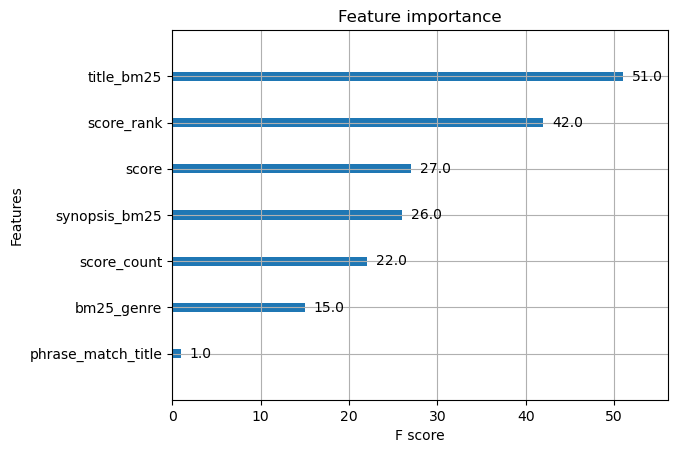

In [88]:
from xgboost import plot_importance

plot_importance(ranker, importance_type="weight");

In [89]:
features, animes = extract_query_features_without_docs({"query": "Attack on Titan"})
features_names_to_pred = list(features.columns)[1:]
y_pred = ranker.predict(features[features_names_to_pred])
animes['relevance'] = y_pred
animes = animes.sort_values(by=['relevance'], ascending=False)

In [90]:
animes

,anime_id,anime_url,title,synopsis,main_pic,type,source_type,num_episodes,status,start_date,end_date,season,studios,genres,score,pics,relevance
3,9203,https://myanimelist.net/anime/9203/K-On__Ura-On,K-On!!: Ura-On!!,"Extra short anime ""Ura-On!!"" included in the l...",https://cdn.myanimelist.net/images/anime/10/25...,Special,Original,9,Finished Airing,2010-07-30T00:00:00,2011-03-16T00:00:00,,Kyoto Animation,Comedy,6.56,https://cdn.myanimelist.net/images/anime/10/25...,1.406365
5,40808,https://myanimelist.net/anime/40808/Jewelpet__...,Jewelpet: Attack Travel!,"Ruby, Garnet, and the other familiar, jewel-ey...",https://cdn.myanimelist.net/images/anime/1229/...,Movie,Original,1,Not yet aired,None,None,,Ashi Production,Adventure,0.10,https://cdn.myanimelist.net/images/anime/1229/...,0.401170
9,38133,https://myanimelist.net/anime/38133/Zhu_Zhu_Xi...,Zhu Zhu Xia: Yong Chuang Juren Dao,Jack the Robber loses his magic bean. G.G. Bon...,https://cdn.myanimelist.net/images/anime/1784/...,Movie,Original,1,Finished Airing,2014-05-31T00:00:00,2014-05-31T00:00:00,,,Sci-Fi|Super Power|Kids,0.10,https://cdn.myanimelist.net/images/anime/1784/...,0.377286
4,7017,https://myanimelist.net/anime/7017/K-On__Ura-On,K-On!: Ura-On!,The seven Blu-ray disc volumes of K-ON! have a...,https://cdn.myanimelist.net/images/anime/9/234...,Special,Original,7,Finished Airing,2009-07-29T00:00:00,2010-01-20T00:00:00,,Kyoto Animation,Comedy,6.37,https://cdn.myanimelist.net/images/anime/9/234...,-0.377785
1,35122,https://myanimelist.net/anime/35122/Shingeki_n...,Shingeki no Kyotou,A special anime featuring a battle against the...,https://cdn.myanimelist.net/images/anime/3/847...,Special,Manga,1,Finished Airing,2017-04-10T00:00:00,2017-04-10T00:00:00,,,Action|Fantasy|Shounen,6.56,https://cdn.myanimelist.net/images/anime/3/847...,-0.705383
6,39363,https://myanimelist.net/anime/39363/Astro_Boy_...,Astro Boy: Tetsuwan Atom - 10-man Kounen no Ra...,Japan's first fully animated IMAX anime film. ...,https://cdn.myanimelist.net/images/anime/1401/...,Movie,Manga,1,Finished Airing,2005-09-01T00:00:00,2005-09-01T00:00:00,,,Sci-Fi|Mecha|Space|Kids,6.62,https://cdn.myanimelist.net/images/anime/1401/...,-0.722557
0,43745,https://myanimelist.net/anime/43745/Attack_Zer...,Attack Zero x Evangelion,Web commercial for chemical and cosmetics comp...,https://cdn.myanimelist.net/images/anime/1662/...,ONA,Original,1,Finished Airing,2020-11-02T00:00:00,2020-11-02T00:00:00,,Wit Studio|Studio DURIAN,Slice of Life|Music,5.15,https://cdn.myanimelist.net/images/anime/1662/...,-0.821681
2,85,https://myanimelist.net/anime/85/Mobile_Suit_Z...,Mobile Suit Zeta Gundam,"It is Universal Century 0087, and the One Year...",https://cdn.myanimelist.net/images/anime/1338/...,TV,Original,50,Finished Airing,1985-03-02T00:00:00,1986-02-22T00:00:00,Spring 1985,Sunrise,Drama|Romance|Sci-Fi|Mecha|Military|Space,7.88,https://cdn.myanimelist.net/images/anime/6/111...,-1.290727
8,18397,https://myanimelist.net/anime/18397/Shingeki_n...,Shingeki no Kyojin OVA,"During the Survey Corps' 49th recon mission, H...",https://cdn.myanimelist.net/images/anime/9/592...,OVA,Manga,3,Finished Airing,2013-12-09T00:00:00,2014-08-08T00:00:00,,Wit Studio,Action|Drama|Fantasy|Super Power|Shounen,7.90,https://cdn.myanimelist.net/images/anime/2/492...,-1.290727
7,31374,https://myanimelist.net/anime/31374/Shingeki_K...,Shingeki! Kyojin Chuugakkou,"On his first day of junior high, Eren Yeager c...",https://cdn.myanimelist.net/images/anime/3/754...,TV,Manga,12,Finished Airing,2015-10-04T00:00:00,2015-12-20T00:00:00,Fall 2015,Production I.G,Comedy|Parody|School|Shounen,7.17,https://cdn.myanimelist.net/images/anime/3/754...,-1.762353
